In [1]:
import numpy as np
import pandas as pd
import os
import glob
import time

import PIL
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import keras
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input,Flatten, Dropout,GlobalMaxPooling2D,Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img
from tensorflow.keras.utils import to_categorical

from sklearn import metrics

# **1. Loading the Data**

In [2]:
path='/kaggle/input/100-bird-species/'
train = '/kaggle/input/100-bird-species/train'
valid = '/kaggle/input/100-bird-species/valid'
test = '/kaggle/input/100-bird-species/test'

In [3]:
labels_dataframe = pd.read_csv('/kaggle/input/100-bird-species/birds.csv')
bird_labels = sorted(list(set(labels_dataframe['labels'])))
num_classes = len(bird_labels)
class_to_num = dict(zip(bird_labels, range(num_classes)))

In [4]:
train_frame=labels_dataframe[labels_dataframe['data set']=="train"]
valid_frame=labels_dataframe[labels_dataframe['data set']=="valid"]
test_frame=labels_dataframe[labels_dataframe['data set']=="test"]

In [5]:
train_frame['file_path'] = train_frame['filepaths'].apply(lambda x:path+f"{x}")
train_frame['labels'] = train_frame.labels.map(class_to_num)
valid_frame['file_path'] = valid_frame['filepaths'].apply(lambda x:path+f"{x}")
valid_frame['labels'] = valid_frame.labels.map(class_to_num)
test_frame['file_path'] = test_frame['filepaths'].apply(lambda x:path+f"{x}")
test_frame['labels'] = test_frame.labels.map(class_to_num)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

**Data Augmentation**

In [6]:
image_datagen = ImageDataGenerator(rescale=1/255.)

In [7]:
train_img=image_datagen.flow_from_directory(train, target_size=(224,224),
                                               class_mode='categorical',batch_size=32)
val_img=image_datagen.flow_from_directory(valid, target_size=(224,224),
                                           class_mode='categorical',batch_size=32)
test_img=image_datagen.flow_from_directory(test, target_size=(224,224),
                                           class_mode='categorical',batch_size=32)

Found 70626 images belonging to 450 classes.
Found 2250 images belonging to 450 classes.
Found 2250 images belonging to 450 classes.


In [9]:
class_names = train_img.class_indices
classes=[*class_names]

# **1st Model InceptionV3**

In [ ]:
inception = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False,input_shape=(224,224,3))

In [ ]:
inception.trainable = True
for layer in inception.layers[:197]:
    layer.trainable = False 

In [ ]:
last_layer = inception.get_layer('mixed7')

layer_output = last_layer.output

In [ ]:
x = Flatten()(layer_output)
x = Dense(1024,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.4)(x)
x = Dense(450, activation='softmax')(x)

model1 = Model(inputs=inception.inputs, outputs=x)

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
model1.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
history1 = model1.fit(
            train_img,
            validation_data = val_img,
            epochs = 20,
callbacks=[callback])

In [ ]:
model1.evaluate(test_img)

In [ ]:
model1.save('mod1.h5')

In [ ]:
model1=tf.keras.models.load_model('/kaggle/input/modelsfinal/mod_1.h5')

In [ ]:
model1.evaluate(test_img)

In [ ]:
def load_and_prep_image1(filename, img_shape = 224):
  img = tf.io.read_file(filename) #read image
  img = tf.image.decode_image(img) # decode the image to a tensor
  img = tf.image.resize(img, size = [img_shape, img_shape]) # resize the image
  img = img/255. # rescale the image
  return img

In [ ]:
def pred_and_plot1(filename, class_names):

  # Import the target image and preprocess it
  img = load_and_prep_image1(filename)

  # Make a prediction
  pred = model_1.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[pred.argmax()]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [ ]:
pred_and_plot1("/kaggle/input/100-bird-species/images to test/3.jpg", classes)

# **2nd Model Xception**

In [ ]:
from keras.applications.xception import Xception

In [ ]:
xceptionnet = Xception( include_top=False , weights="imagenet" , input_shape=(224,224,3))

In [ ]:
xceptionnet.trainable=True

for layer in xceptionnet.layers[:-20]:
  layer.trainable=False

In [ ]:
model2 = Sequential([
    xceptionnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(450,activation='softmax')
])

model2.summary()

In [ ]:
model2.compile( optimizer='adam', loss="categorical_crossentropy" , metrics=["accuracy"] )

In [ ]:
history2=model2.fit(train_img,
            validation_data = val_img,
            epochs = 10)

In [ ]:
model2.evaluate(test_img)

In [ ]:
model2.save('mod_2.h5')

# **Ensmebling**

In [ ]:
model1=tf.keras.models.load_model('/kaggle/input/modelsfinal/mod_1.h5')
model2=tf.keras.models.load_model('/kaggle/input/modelsfinal/mod_2.h5')

**Stacking**

![stacking](https://editor.analyticsvidhya.com/uploads/32394stacked.png)


In [ ]:
from keras.layers.merge import concatenate

In [ ]:
model1.evaluate(test_img)

In [ ]:
model_1=tf.keras.Model(inputs=model1.inputs,
             outputs=model1.outputs,
             name='model_1_name')
model_2=tf.keras.Model(inputs=model2.inputs,
             outputs=model2.outputs,
             name='model_2_name')

In [ ]:
models=[model_1,model_2]
model_input=Input(shape=(224,224,3))
model_outputs=[model(model_input) for model in models]
ensemble_output=tf.keras.layers.Concatenate()(model_outputs)
x = BatchNormalization()(ensemble_output)
x = Dense(1024,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.4)(x)
x = Dense(450, activation='softmax')(x)
ensemble_model=tf.keras.Model(inputs=model_input,outputs=x,name='ensemble')

In [ ]:
ensemble_model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
hist_ens=ensemble_model.fit(train_img,
            validation_data = val_img,
            epochs = 5,
callbacks=[callback])

In [ ]:
ensemble_model.evaluate(test_img)

In [ ]:
ensemble_model.save('ens_model_final_2')

**LOAD ALL MODELS**

In [ ]:
mod1=tf.keras.models.load_model('/kaggle/input/modelsfinal/mod_1.h5')

In [ ]:
mod2=tf.keras.models.load_model('/kaggle/input/modelsfinal/mod_2.h5')

In [ ]:
mod1.evaluate(test_img)

In [ ]:
mod2.evaluate(test_img)

In [10]:
mod_ens=tf.keras.models.load_model('/kaggle/working/ens_model_final_2')

2023-01-31 13:33:39.148039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 13:33:39.387945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 13:33:39.389350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 13:33:39.391312: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
mod_ens.evaluate(test_img)

2023-01-31 13:35:47.752634: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-31 13:35:50.438215: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


71/71 [==============================] - 25s 230ms/step - loss: 0.2461 - accuracy: 0.9822


[0.2460528463125229, 0.9822221994400024]

In [12]:
def load_and_prep_image(filename, img_shape = 224):
  img = tf.io.read_file(filename) #read image
  img = tf.image.decode_image(img) # decode the image to a tensor
  img = tf.image.resize(img, size = [img_shape, img_shape]) # resize the image
  img = img/255. # rescale the image
  return img

In [15]:
def pred_and_plot(filename, class_names):

  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = mod_ens.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[pred.argmax()]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

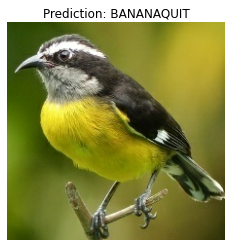

In [20]:
pred_and_plot("/kaggle/input/100-bird-species/test/BANANAQUIT/4.jpg", classes)